In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
import torch.optim as optim
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plot
import time
import math
from torch.autograd.variable import Variable

In [2]:
class Detector(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.tread0 = nn.Sequential(nn.Linear(784,507), nn.LeakyReLU(0.2), nn.Dropout(0.3))
        self.tread1 = nn.Sequential(nn.Linear(507,169), nn.LeakyReLU(0.2), nn.Dropout(0.3))
        self.tread2 = nn.Sequential(nn.Linear(169,81), nn.LeakyReLU(0.2), nn.Dropout(0.3))
        self.tread3 = nn.Sequential(nn.Linear(81,1), nn.Sigmoid())
        
    def forward(self, x):
        x = self.tread0(x)
        x = self.tread1(x)
        x = self.tread2(x)
        x = self.tread3(x)
        return x
    
    def repair(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
   
    
class Forger(nn.Module):
    def __init__(self):
        super().__init__()
        self.tread0 = nn.Sequential(nn.Linear(200, 400), nn.LeakyReLU(0.2))
        self.tread1 = nn.Sequential(nn.Linear(400, 600), nn.LeakyReLU(0.2))
        self.tread2 = nn.Sequential(nn.Linear(600, 800), nn.LeakyReLU(0.2))
        self.tread3 = nn.Sequential(nn.Linear(800, 784), nn.Tanh())
        
    def forward(self, x):
        x = self.tread0(x)
        x = self.tread1(x)
        x = self.tread2(x)
        x = self.tread3(x)
        return x
        
    def repair(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
detector = Detector()
forger = Forger()

print(detector)
print(forger)


Detector(
  (tread0): Sequential(
    (0): Linear(in_features=784, out_features=507, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (tread1): Sequential(
    (0): Linear(in_features=507, out_features=169, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (tread2): Sequential(
    (0): Linear(in_features=169, out_features=81, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (tread3): Sequential(
    (0): Linear(in_features=81, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Forger(
  (tread0): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (tread1): Sequential(
    (0): Linear(in_features=400, out_features=600, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (tread2): Sequential(
    (0): Linear(in_features=600, out_features=800, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (tread3): Sequential(
    (

In [3]:
# Helper Functions
def ItoV(x):
    return x.view(x.size(0),784)

def VtoI(v):
    return v.view(v.size(0),1,28,28)

# Generator Input
def Noise(R):
    # x is for the number of input nodes in the generator, in this case, 200
    x = 200
    # R is for the amount of samples
    n = Variable(torch.randn(R, x))
    return n

In [4]:
pi = tf.Compose([tf.ToTensor(),tf.Normalize((.5,.5,.5),(.5,.5,.5))])

In [5]:
# Getting MNIST
beta = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=pi)
peta = torch.utils.data.DataLoader(beta, batch_size = 100, shuffle = True)
batches = len(peta)
print (batches)

600


In [6]:
def show(i):
    image = i.numpy()
    plot.imshow(numpy.transpose(image,(1,2,0)))

In [7]:
#loss/optimization functions
gamma = nn.BCELoss()
DetectiveOptim = optim.Adam(detector.parameters(), lr = 0.0002)
ForgerOptim = optim.Adam(forger.parameters(), lr = 0.0002)

In [8]:
# for detector optimization, real is 1, fake is 0
def ones(s):
    d = Variable(torch.ones(s, 1))
    return d
    
def zeroes(s):
    d = Variable(torch.zeros(s, 1))
    return d

In [9]:
def trainDetective(opto, real, fake):
    N = real.size(0)
    opto.zero_grad()
    predic_real = detector(real)
    error_real = gamma(predic_real, ones(N))
    error_real.backward()
    predic_fake = detector(fake)
    error_fake = gamma(predic_fake, zeroes(N))
    error_fake.backward()
    opto.step()
    
    return error_real + error_fake, predic_real, predic_fake

In [10]:
def trainForger(opto, fake):
    N = fake.size(0)
    opto.zero_grad()
    predic = detector(fake)
    error = gamma(predic, ones(N))
    error.backward()
    opto.step()
    
    return error

In [11]:
epochlist = []
Timer = []

In [37]:
#Needs around 100 epochs to train effectively
for epoch in range(50):
    curtime = time.time()
    if epoch%5 == 0:
        print(epoch)
    for batch, (realbatch,_) in enumerate(peta):
        ##1
        N = realbatch.size(0)
        real = Variable(ItoV(realbatch))
        fake = forger(Noise(N)).detach()
        trainDetective(DetectiveOptim, real, fake)
        
        ##2
        fake = forger(Noise(N))
        trainForger(ForgerOptim, fake)
    with torch.no_grad():
        epochlist.append(forger(Noise(25)))
    Timer.append(time.time()-curtime)


0
5
10
15
20
25
30
35
40
45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


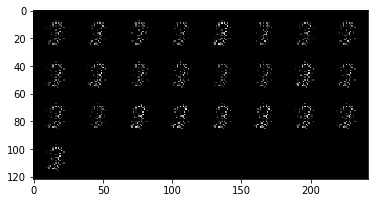

In [38]:
show(torchvision.utils.make_grid(VtoI(epochlist[1])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


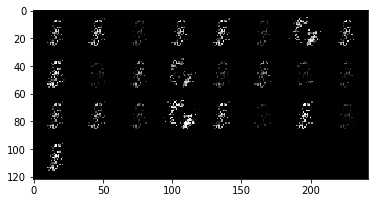

In [39]:
show(torchvision.utils.make_grid(VtoI(epochlist[5])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


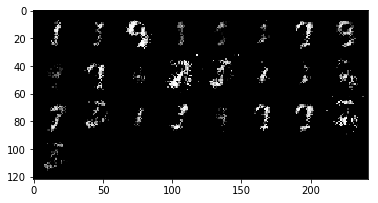

In [40]:
show(torchvision.utils.make_grid(VtoI(epochlist[10])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


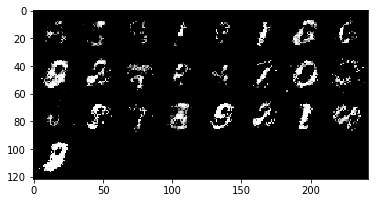

In [41]:
show(torchvision.utils.make_grid(VtoI(epochlist[20])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


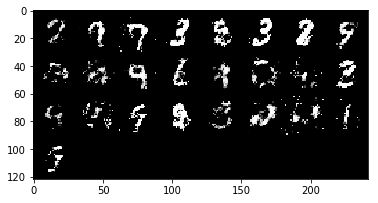

In [42]:
show(torchvision.utils.make_grid(VtoI(epochlist[30])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


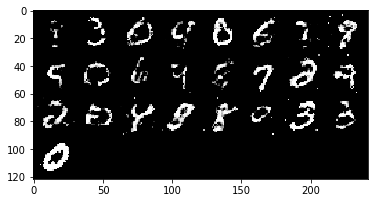

In [43]:
show(torchvision.utils.make_grid(VtoI(epochlist[-1])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


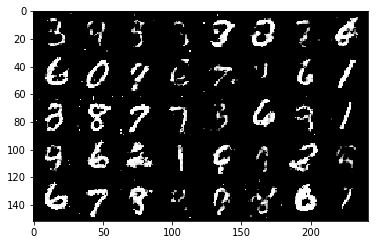

In [54]:
#make something new with the current generator
with torch.no_grad():
    numberu = forger(Noise(40))
numberu_pic = VtoI(numberu)
show(torchvision.utils.make_grid(numberu_pic))

In [55]:
#average time per epoch
e = 0
for i in Timer:
    e += i
e/len(Timer)

23.90810744397275